In [1]:
!pip install -q kaggle

É necessário passar o arquivo kaggle.json para seu diretório local do Google Colab

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Dataset completo

In [47]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space

  0% 0.00/2.94M [00:00<?, ?B/s]
100% 2.94M/2.94M [00:00<00:00, 136MB/s]


In [49]:
!unzip planet-understanding-the-amazon-from-space.zip

Archive:  planet-understanding-the-amazon-from-space.zip
  inflating: Kaggle-planet-test-tif.torrent  
  inflating: Kaggle-planet-train-tif.torrent  
  inflating: sample_submission_v2.csv/sample_submission_v2.csv  
  inflating: test_v2_file_mapping.csv/test_v2_file_mapping.csv  
replace train_v2.csv/train_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train_v2.csv/train_v2.csv  


Baixar pelo torrent

O link para download usando torrent não está funcional... Trabalhem com as imagens em png para a atividade


In [ ]:
!apt install python3-libtorrent

In [ ]:
import libtorrent as lt

ses = lt.session()

info = lt.torrent_info('/content/Kaggle-planet-train-tif.torrent')
h = ses.add_torrent({'ti': info, 'save_path': './'})

print('downloading', h.name())
while not h.is_seed():
    s = h.status()
    print('%.2f%% complete (down: %.1f kB/s up: %.1f kB/s peers: %d) %s' % (
        s.progress * 100, s.download_rate / 1000, s.upload_rate / 1000,
        s.num_peers, s.state))

print('download complete')

Somente as imagens png

In [4]:
!kaggle datasets download prosperchuks/amazonsatelliteimages

Dataset URL: https://www.kaggle.com/datasets/prosperchuks/amazonsatelliteimages
License(s): unknown
 99% 1.49G/1.50G [00:22<00:00, 114MB/s] 
100% 1.50G/1.50G [00:22<00:00, 70.0MB/s]


In [5]:
!unzip amazonsatelliteimages.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train-jpg/train-jpg/train_55.jpg  
  inflating: train-jpg/train-jpg/train_550.jpg  
  inflating: train-jpg/train-jpg/train_5500.jpg  
  inflating: train-jpg/train-jpg/train_5501.jpg  
  inflating: train-jpg/train-jpg/train_5502.jpg  
  inflating: train-jpg/train-jpg/train_5503.jpg  
  inflating: train-jpg/train-jpg/train_5504.jpg  
  inflating: train-jpg/train-jpg/train_5505.jpg  
  inflating: train-jpg/train-jpg/train_5506.jpg  
  inflating: train-jpg/train-jpg/train_5507.jpg  
  inflating: train-jpg/train-jpg/train_5508.jpg  
  inflating: train-jpg/train-jpg/train_5509.jpg  
  inflating: train-jpg/train-jpg/train_551.jpg  
  inflating: train-jpg/train-jpg/train_5510.jpg  
  inflating: train-jpg/train-jpg/train_5511.jpg  
  inflating: train-jpg/train-jpg/train_5512.jpg  
  inflating: train-jpg/train-jpg/train_5513.jpg  
  inflating: train-jpg/train-jpg/train_5514.jpg  
  inflating: train-jpg/train-jpg/train_5515.j

---

In [64]:
# Importando bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Importando bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Importando biblioteca para processamento de imagens
import cv2

# Importando biblioteca para exibir barra de progresso
from tqdm import tqdm_notebook as tqdm

# Importando biblioteca para redução de dimensionalidade
from sklearn.manifold import TSNE

# Importando biblioteca para manipulação de arquivos
import pickle
import os

In [8]:
df = pd.read_csv('/content/train_v2.csv/train_v2.csv')
df

image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]

In [11]:
# Separar as categorias por espaços
tags = df['tags'].apply(lambda x: x.split(' '))

# Fazer uma contagem para todas as imagens
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]


Calculando ocorrência de tags no arquivo

In [15]:
tags_contadas = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False).reset_index(drop=True)
tags_contadas.columns = ['tag', 'count']

Renomear as categorias

In [17]:
tags_contadas['tag'] = tags_contadas['tag'].replace(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy', 'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground', 'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down', 'conventional_mine'], ['primario', 'Limpo', 'Agricultura', 'rodovia', 'agua', 'parcialmente_nubaldo', 'Cultivo', 'habitação', 'neblina', 'nublado', 'chão_descoberto', 'registro_seletivo', 'mina_artesanal', 'florescendo', 'Corte_queima', 'abatimento', 'mineracao_convencional'])
tags_contadas

tag  count
0                 primario  37513
1                    Limpo  28431
2              Agricultura  12315
3                  rodovia   8071
4                     agua   7411
5     parcialmente_nubaldo   7261
6                  Cultivo   4547
7                habitação   3660
8                  neblina   2697
9                  nublado   2089
10         chão_descoberto    862
11       registro_seletivo    340
12          mina_artesanal    339
13             florescendo    332
14            Corte_queima    209
15              abatimento    101
16  mineracao_convencional    100

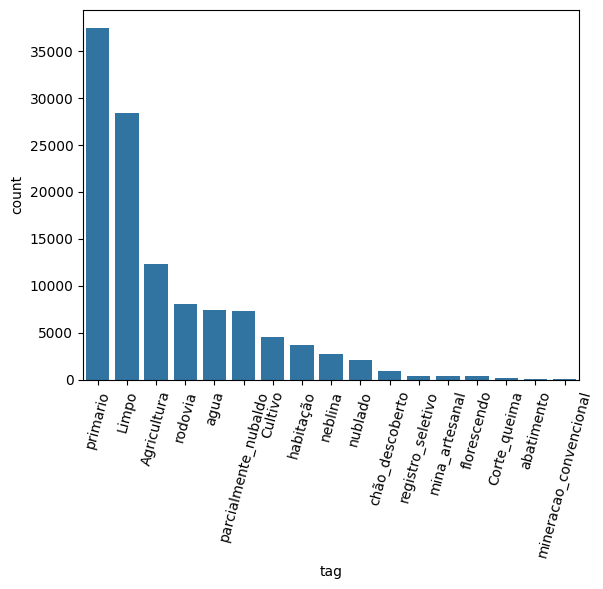

In [23]:
sns.barplot(x='tag', y='count', data=tags_contadas)
plt.xticks(rotation=75)
plt.show()

In [25]:
# função para pegar as tags de casa imagem
def get_tags(img):
    tags = df[df['image_name'] == img]['tags'].values
    return tags[0]

Imprimir uma imagem e destacar as cores através do OpenCV

In [39]:
# Funções para carregar e mostrar imagens
jpg_image_path = '/content/train-jpg/train-jpg/{}.jpg'
tif_image_path = '/content/train-tif-v2/{}.tif' # não tem isso no dataset que estou usando

def get_image(name, form):
    if form == 'jpg':
        img = cv2.imread(jpg_image_path.format(name))
    elif form == 'tif':
        img = cv2.imread(tif_image_path.format(name), flags=cv2.IMREAD_UNCHANGED)
    else:
        print('Image format must be jpg or tif')
    return img

def show_image(img, *caption):
    if img.shape == (256, 256, 3):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        for caption in caption:
            plt.annotate(caption, xy=(3, 248), color='w')
    elif img.shape == (256, 256, 4):
        channels = cv2.split(img)
        f, ax = plt.subplots(1, 4, figsize=(18, 4))
        ax[0].imshow(channels[0], cmap='nipy_spectral')
        ax[1].imshow(channels[1], cmap='nipy_spectral')
        ax[2].imshow(channels[2], cmap='nipy_spectral')
        ax[3].imshow(channels[3], cmap='nipy_spectral')
        # Gerar legendas
        ax[0].set_title('Canal azul intensificado')
        ax[1].set_title('Canal verde intensificado')
        ax[2].set_title('Canal vermelho intensificado')
        ax[3].set_title('Canal infravermelho intensificado')
    else:
        print('Imagem inválida')
    plt.show()

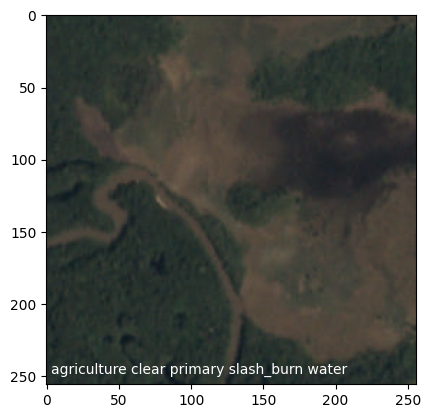

In [55]:
# Mostrar exemplo de imagem
example_image_name = 'train_10'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))

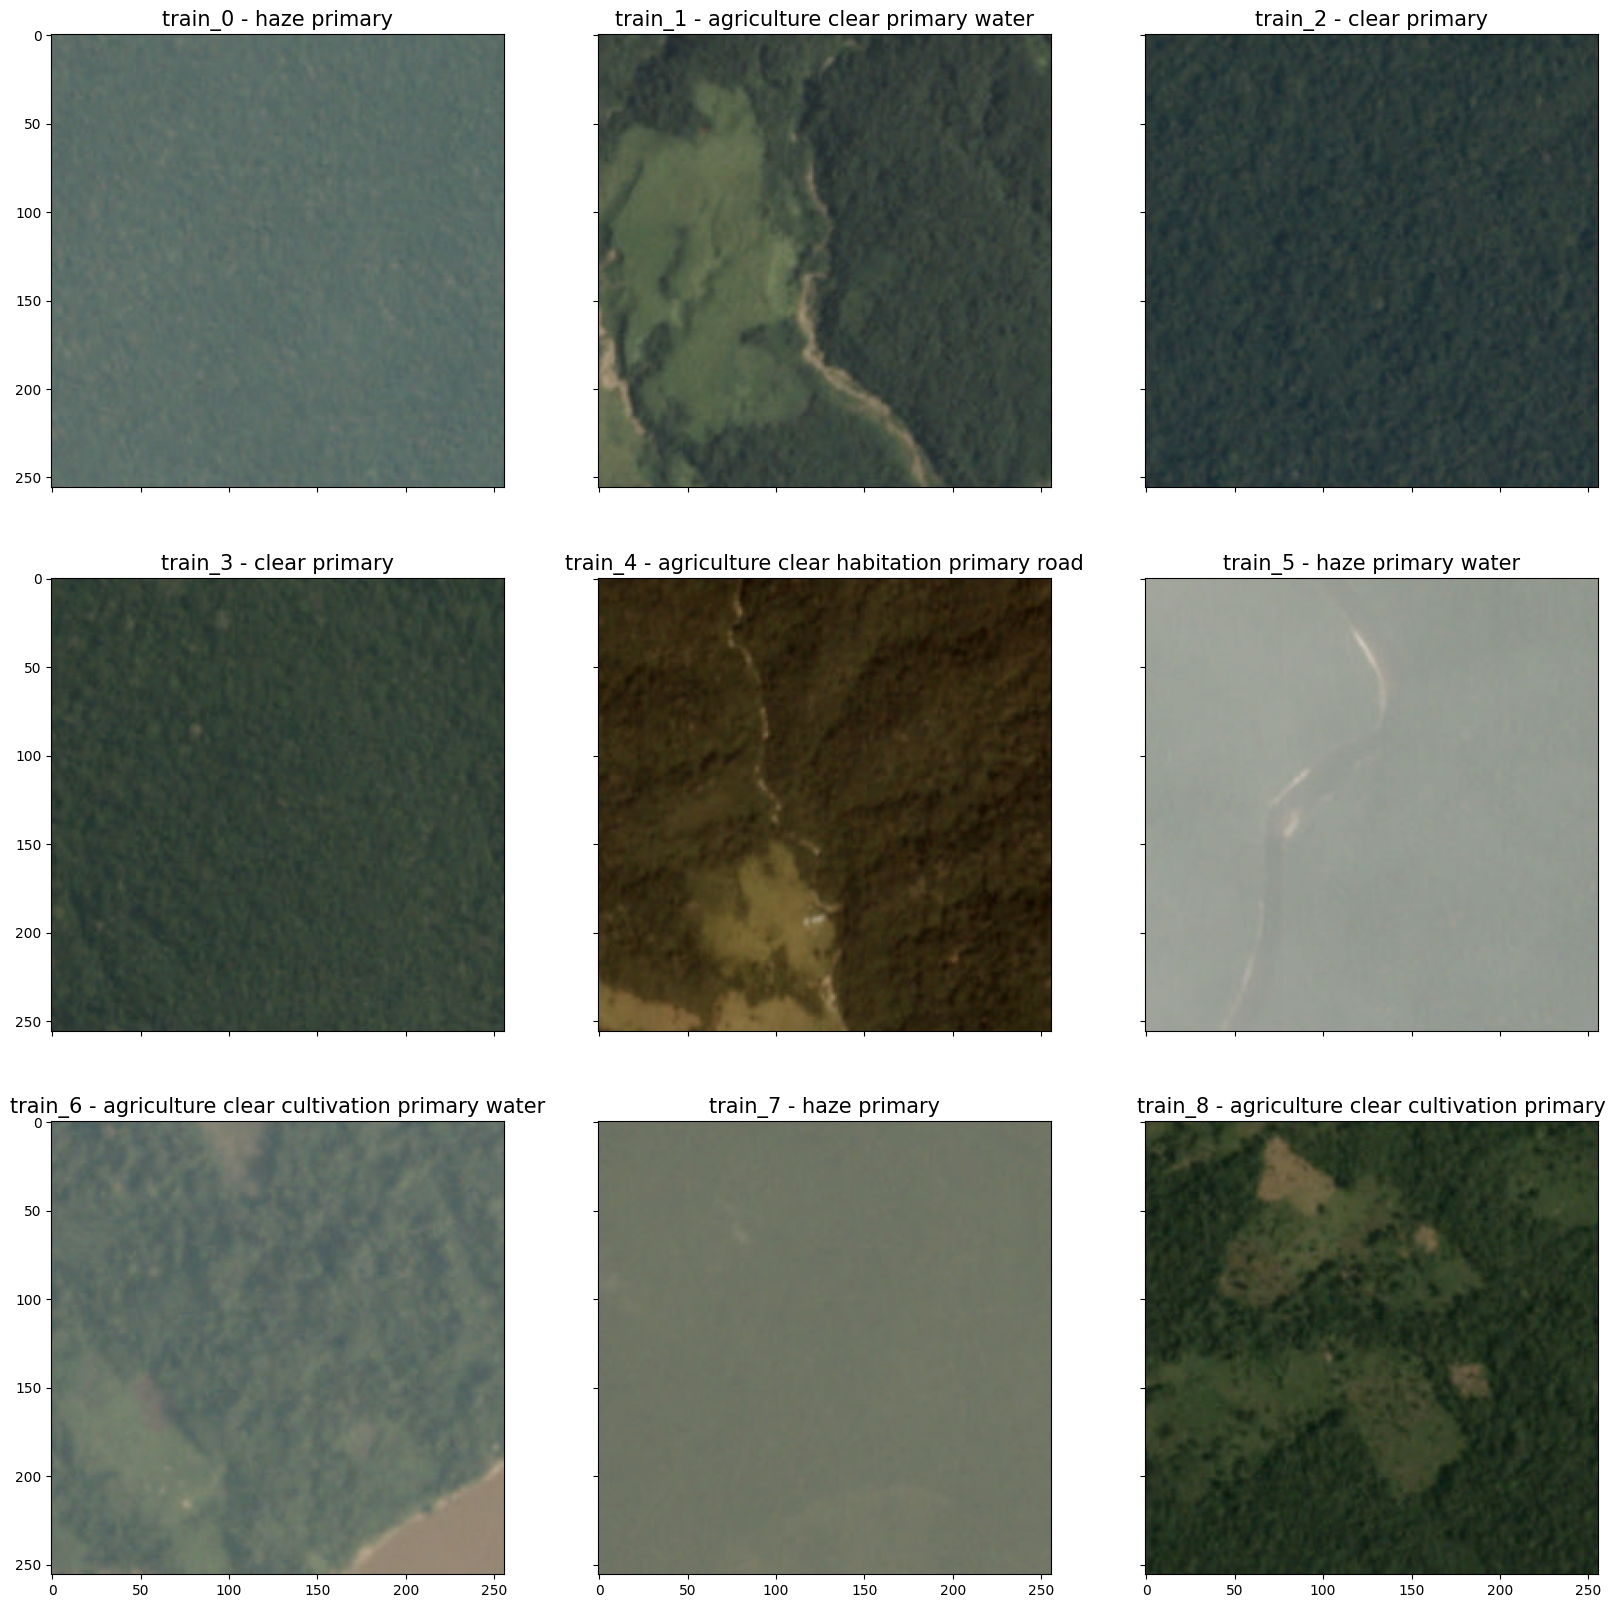

In [56]:
#plotando 9 imagens
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

i = 0
for f, l in df[:9].values:

    img = cv2.imread(jpg_image_path.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l), fontsize=15)
    i += 1

plt.show()

## Salvando as imagens em um arquivo binário para processamento

In [58]:
def get_images_mat(image_names):
    all_imgs = []
    for image_name in tqdm(image_names):
        img = get_image(image_name, 'jpg')
        img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
        img = img.reshape(1, -1)
        all_imgs.append(img)
    img_mat = np.vstack(all_imgs)
    return img_mat

função para plotar imagens como um gráfico de dispersão usando as coordenadas tsne

In [60]:
def imscatter(tsne, images_list, ax=None, zoom=0.2):

    assert len(tsne) == len(images_list)

    n_imgs=len(tsne)

    x = tsne[0:n_imgs,0]
    y = tsne[0:n_imgs,1]
    images = [get_image(images_list.iloc[i], 'jpg') for i in range(n_imgs)]

    plt.figure(figsize=(20,20))
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [61]:
all_images_sample = df.sample(1000, random_state=42) # imagens aleatórias para ilustração
img_mat = get_images_mat(all_images_sample['image_name'])

tsne = TSNE(
    n_components=2,
    perplexity=30,
    init='random',
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    learning_rate=200,
    verbose=1
).fit_transform(img_mat)

<ipython-input-58-96855a95431f>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_name in tqdm(image_names):


  0%|          | 0/1000 [00:00<?, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.079s...
[t-SNE] Computed neighbors for 1000 samples in 19.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 24.521661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.511780
[t-SNE] KL divergence after 1000 iterations: 1.396397


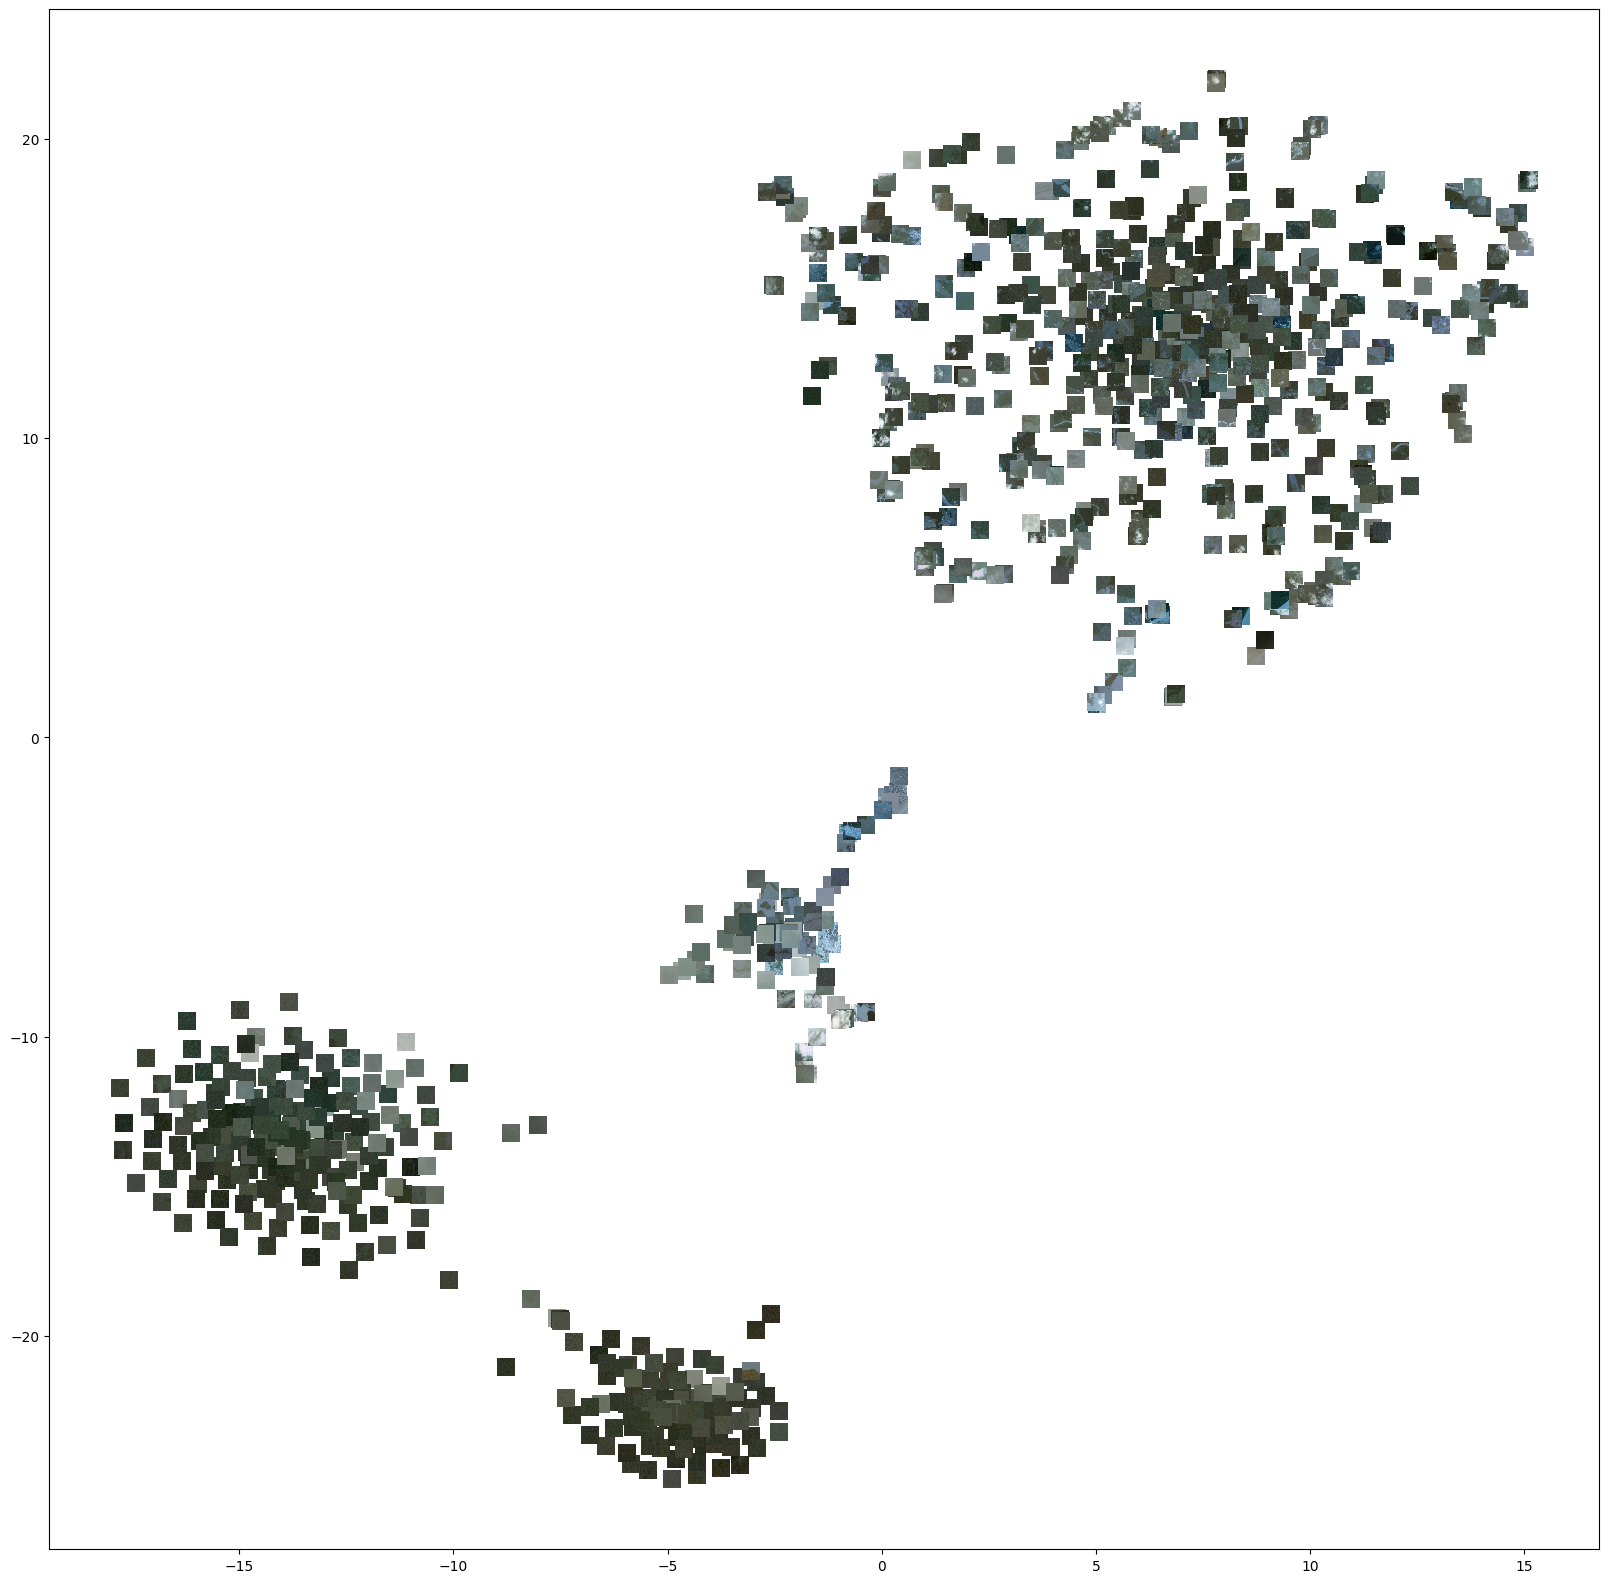

In [62]:
imscatter(tsne=tsne, images_list=all_images_sample['image_name'], zoom=0.05)

## Clustering para identificação de características da imagem

In [65]:
from matplotlib.image import imread
from sklearn.cluster import KMeans

In [66]:
# Criamos uma função para a leitura da imagem
def imageAnalysis(number):
    img = imread('./train-jpg/train-jpg/train_{}.jpg'.format(number))
    img=cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB)
    X = img.reshape(-1,3)
    # regularização da imagem para obter 3 cores diferentes das imagens
    kmeans = KMeans(n_clusters=3).fit(X)
    img2 = kmeans.cluster_centers_[kmeans.labels_]
    img2 = img2.reshape(img.shape)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    # calcular a porcentagem de cada cor presente
    percent=[]
    for i in range(len(centroid)):
        j=labels.count(i)
        j=j/(len(labels))
        percent.append(j)
    print(df['tags'][number])
    fig = plt.figure()
    plt.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)),autopct='%.0f%%')
    plt.show()
    plt.imshow(img2.astype('uint8'))

Fazer um teste

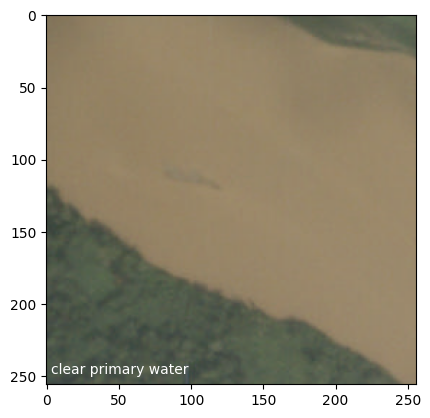

In [68]:
# Mostrar exemplo de imagem
example_image_name = 'train_30'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clear primary water


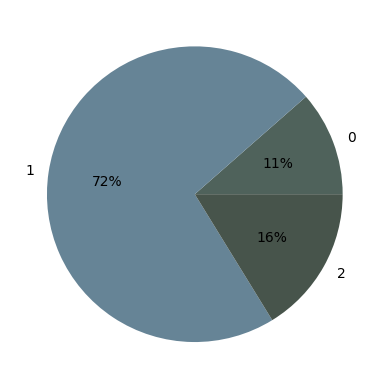

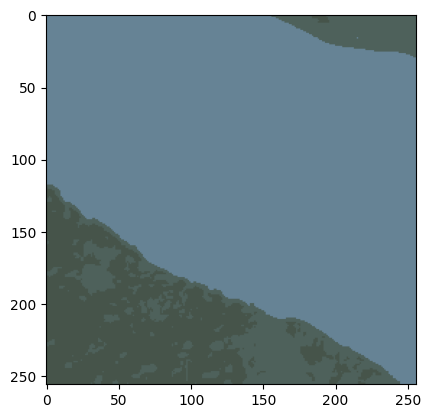

In [67]:
imageAnalysis(30)

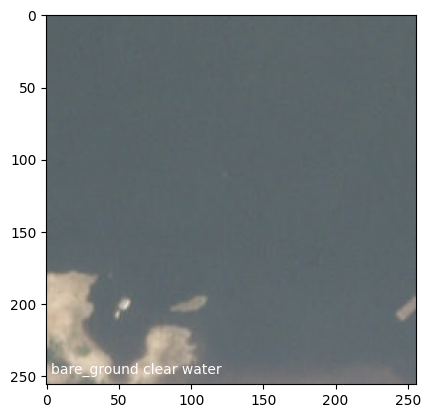

In [69]:
# Mostrar exemplo de imagem
example_image_name = 'train_100'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


bare_ground clear water


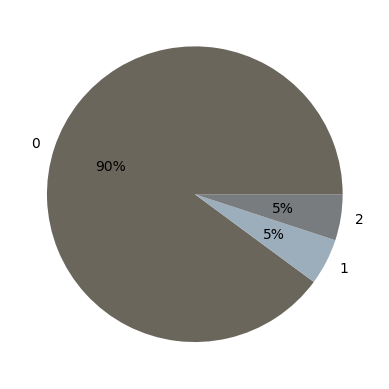

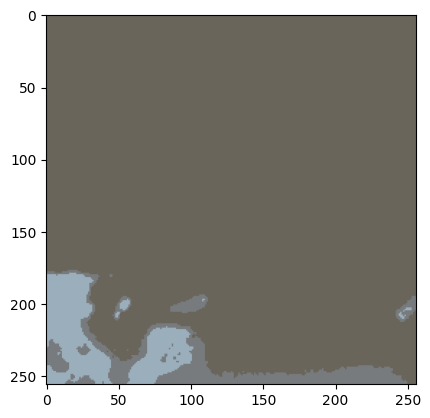

In [70]:
imageAnalysis(100)